# RL Project - Highway

In this project I will train an agent to navigate on a highway, and hopefully avoid crashing. The OpenAI Gymnasium environment is called [HighwayEnv](https://github.com/Farama-Foundation/HighwayEnv) and is made by [Farama-Foundation](https://github.com/Farama-Foundation/).


> In this task, the ego-vehicle is driving on a multilane highway populated with other vehicles. The agent's objective is to reach a high speed while avoiding collisions with neighbouring vehicles. Driving on the right side of the road is also rewarded.
> -***HighwayEnv's GitHub repository***

&nbsp;

I was tasked with choosing one or more algorithms I will try, and explain my choice. I also have to train multiple algorithms (or the same algorithm using different hyperparameters)

---

In [1]:
import gymnasium
from IPython import display
import matplotlib.pyplot as plt
import numpy as np

from keras.models import load_model

import random
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

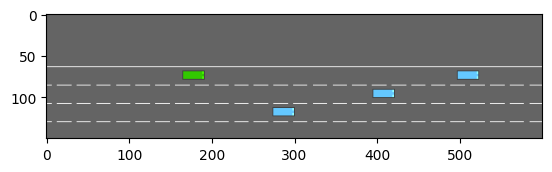

In [2]:
env = gymnasium.make('highway-v0', render_mode="rgb_array")
env.reset()

img = plt.imshow(env.render())

In [3]:
from gymnasium.wrappers import RecordVideo

## 0. Random actions

In [4]:
directory = "./videos/random"
env = RecordVideo(gymnasium.make("highway-v0", render_mode="rgb_array"),
                  video_folder = directory)

observation = env.reset()
epochs = 0
penalties, reward = 0, 0
done = False

# max_epochs = 1000
# while not done and epochs < max_epochs:

while not done:
    action = env.action_space.sample()
    state, reward, done, truncated, info = env.step(action)

    if reward == -10:
        penalties += 1
    epochs += 1
    

print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

c:\Users\Harman\miniconda3\envs\gymenv\Lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\Harman\Desktop\RL-Project-highway\videos\random folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video c:\Users\Harman\Desktop\RL-Project-highway\videos\random\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\Harman\Desktop\RL-Project-highway\videos\random\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Harman\Desktop\RL-Project-highway\videos\random\rl-video-episode-0.mp4
Timesteps taken: 12
Penalties incurred: 0


## 1. **Deep Q-Networks (DQN)**

The first algorithm I will try out is Deep Q-Networks (DQN). The reasons for trying this algorithm are the followingL

1. **Suitability for discrete action spaces**: DQN is well-suited for environments with discrete action spaces, where the agent must choose from a finite set of actions at each time step.
   
2. **Simplicity and ease of implementation**: DQN is relatively simple to understand and implement compared to some other advanced reinforcement learning algorithms.

### Implementation of Deep Q-Networks (DQN)

Define DQN class

In [5]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size**2, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)  # Explore
        else:
            return np.argmax(self.model.predict(state))  # Exploit

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


Create the environment with video recording

In [6]:
directory = "./videos/DQN"
env = RecordVideo(gymnasium.make("highway-v0", render_mode="rgb_array"),
                  video_folder = directory)

state_size = env.observation_space.shape[0]
action_size = env.action_space.n

c:\Users\Harman\miniconda3\envs\gymenv\Lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\Harman\Desktop\RL-Project-highway\videos\DQN folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Run the algorithm

*(exec time: `4:24`)*

In [7]:
# Initialize DQN agent
agent = DQNAgent(state_size, action_size)

# Set hyperparameters
batch_size = 32
num_episodes = 25


# DQN algorithm
for episode in range(num_episodes):
    state_tuple = env.reset()
    state = state_tuple[0]  # Assuming the state is the first element of the tuple
    print("State shape:", state.shape)
    print("State type:", type(state))
    state = np.reshape(state, [1, 25])
    done = False
    total_reward = 0

    while not done:
        action = agent.act(state)
        next_state, reward, done, _, _ = env.step(action)
        total_reward += reward
        next_state = np.reshape(next_state, [1, 25])
        agent.remember(state, action, reward, next_state, done)
        state = next_state

    if len(agent.memory) > batch_size:
        agent.replay(batch_size)
    
    print("Episode: {}, Total Reward: {}, Epsilon: {:.2f}".format(episode + 1, total_reward, agent.epsilon))

c:\Users\Harman\miniconda3\envs\gymenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


State shape: (5, 5)
State type: <class 'numpy.ndarray'>
Moviepy - Building video c:\Users\Harman\Desktop\RL-Project-highway\videos\DQN\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\Harman\Desktop\RL-Project-highway\videos\DQN\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Harman\Desktop\RL-Project-highway\videos\DQN\rl-video-episode-0.mp4
Episode: 1, Total Reward: 16.84228747402508, Epsilon: 1.00
State shape: (5, 5)
State type: <class 'numpy.ndarray'>


Moviepy - Building video c:\Users\Harman\Desktop\RL-Project-highway\videos\DQN\rl-video-episode-1.mp4.
Moviepy - Writing video c:\Users\Harman\Desktop\RL-Project-highway\videos\DQN\rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Harman\Desktop\RL-Project-highway\videos\DQN\rl-video-episode-1.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━

Moviepy - Done !
Moviepy - video ready c:\Users\Harman\Desktop\RL-Project-highway\videos\DQN\rl-video-episode-8.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━

### Save the model

because God knows I'm not training the whole thing again :)

In [8]:
model_save_path = "./models/dqn_model.keras"
agent.model.save(model_save_path)
print("Trained model saved to:", model_save_path)

Trained model saved to: ./models/dqn_model.keras


In [9]:
loaded_model = load_model(model_save_path)

## 2. **Deep Q-Networks (DQN) with `stable_baselines3`**



The DQN algorithm is also available in `stable_baselines3`, so I will try it out again with this for the following reasons:

1. **Same as non-`stable_baselines3` DQN**: All the same reasons 
   
2. **Simplicity and ease of implementation**: The `stable_baselines3` version of DQN is even simpler to understand and implement.

### Implementation of Deep Q-Networks (DQN) with `stable_baselines3`

In [10]:
from stable_baselines3 import DQN

directory = "./videos/DQN-stable-baselines3"
env = RecordVideo(gymnasium.make("highway-v0", render_mode="rgb_array"),
                  video_folder = directory)


dqn_model = DQN("MlpPolicy", env, verbose=1)
dqn_model.learn(total_timesteps=100, log_interval=10)
dqn_model.save("./models/dqn_sb3_model.keras")

c:\Users\Harman\miniconda3\envs\gymenv\Lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\Harman\Desktop\RL-Project-highway\videos\DQN-stable-baselines3 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Moviepy - Building video c:\Users\Harman\Desktop\RL-Project-highway\videos\DQN-stable-baselines3\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\Harman\Desktop\RL-Project-highway\videos\DQN-stable-baselines3\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Harman\Desktop\RL-Project-highway\videos\DQN-stable-baselines3\rl-video-episode-0.mp4


Moviepy - Building video c:\Users\Harman\Desktop\RL-Project-highway\videos\DQN-stable-baselines3\rl-video-episode-1.mp4.
Moviepy - Writing video c:\Users\Harman\Desktop\RL-Project-highway\videos\DQN-stable-baselines3\rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Harman\Desktop\RL-Project-highway\videos\DQN-stable-baselines3\rl-video-episode-1.mp4


### Evaluate policy

In [12]:
from stable_baselines3.common.evaluation import evaluate_policy
evaluate_policy(dqn_model, env, n_eval_episodes=10)

c:\Users\Harman\miniconda3\envs\gymenv\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Moviepy - Building video c:\Users\Harman\Desktop\RL-Project-highway\videos\DQN-stable-baselines3\rl-video-episode-8.mp4.
Moviepy - Writing video c:\Users\Harman\Desktop\RL-Project-highway\videos\DQN-stable-baselines3\rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Harman\Desktop\RL-Project-highway\videos\DQN-stable-baselines3\rl-video-episode-8.mp4


(11.595650204457343, 6.461209661275868)

## 3. **Proximal Policy Optimization (PPO) with `stable_baselines3`**

### Implementation of Proximal Policy Optimization (PPO) with `stable_baselines3`

In [13]:
from stable_baselines3 import PPO

directory = "./videos/PPO-stable-baselines3"
env = RecordVideo(gymnasium.make("highway-v0", render_mode="rgb_array"),
                  video_folder = directory)


ppo_model = PPO("MlpPolicy", env, verbose=1)
ppo_model.learn(total_timesteps=100, log_interval=10)
ppo_model.save("./models/ppo_sb3_model.keras")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Moviepy - Building video c:\Users\Harman\Desktop\RL-Project-highway\videos\PPO-stable-baselines3\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\Harman\Desktop\RL-Project-highway\videos\PPO-stable-baselines3\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Harman\Desktop\RL-Project-highway\videos\PPO-stable-baselines3\rl-video-episode-0.mp4


Moviepy - Building video c:\Users\Harman\Desktop\RL-Project-highway\videos\PPO-stable-baselines3\rl-video-episode-1.mp4.
Moviepy - Writing video c:\Users\Harman\Desktop\RL-Project-highway\videos\PPO-stable-baselines3\rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Harman\Desktop\RL-Project-highway\videos\PPO-stable-baselines3\rl-video-episode-1.mp4


Moviepy - Building video c:\Users\Harman\Desktop\RL-Project-highway\videos\PPO-stable-baselines3\rl-video-episode-8.mp4.
Moviepy - Writing video c:\Users\Harman\Desktop\RL-Project-highway\videos\PPO-stable-baselines3\rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Harman\Desktop\RL-Project-highway\videos\PPO-stable-baselines3\rl-video-episode-8.mp4


Moviepy - Building video c:\Users\Harman\Desktop\RL-Project-highway\videos\PPO-stable-baselines3\rl-video-episode-27.mp4.
Moviepy - Writing video c:\Users\Harman\Desktop\RL-Project-highway\videos\PPO-stable-baselines3\rl-video-episode-27.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Harman\Desktop\RL-Project-highway\videos\PPO-stable-baselines3\rl-video-episode-27.mp4


Moviepy - Building video c:\Users\Harman\Desktop\RL-Project-highway\videos\PPO-stable-baselines3\rl-video-episode-64.mp4.
Moviepy - Writing video c:\Users\Harman\Desktop\RL-Project-highway\videos\PPO-stable-baselines3\rl-video-episode-64.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Harman\Desktop\RL-Project-highway\videos\PPO-stable-baselines3\rl-video-episode-64.mp4


Moviepy - Building video c:\Users\Harman\Desktop\RL-Project-highway\videos\PPO-stable-baselines3\rl-video-episode-125.mp4.
Moviepy - Writing video c:\Users\Harman\Desktop\RL-Project-highway\videos\PPO-stable-baselines3\rl-video-episode-125.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Harman\Desktop\RL-Project-highway\videos\PPO-stable-baselines3\rl-video-episode-125.mp4


### Evaluate policy

In [14]:
evaluate_policy(ppo_model, env, n_eval_episodes=10)

c:\Users\Harman\miniconda3\envs\gymenv\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


(27.621722597628832, 5.7057658838479)